# Importing Required Libraries

In [1]:
import os
import time
import pickle
import random
import numpy as np
from tqdm import tqdm
from datasets import load_dataset

import torch
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms.functional import pil_to_tensor, to_pil_image

/data/home1/shishirm/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Makeing Results Reproducible

In [2]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

In [3]:
device = 'cuda'
# device = 'cpu'

# Reading The Dataset


In [4]:
directory = './tiny-imagenet/data'
if not os.path.exists(directory):
    os.makedirs(directory)
    !wget https://huggingface.co/datasets/zh-plus/tiny-imagenet/resolve/main/data/train-00000-of-00001-1359597a978bc4fa.parquet?download=true -O ./tiny-imagenet/data/train-00000-of-00001-1359597a978bc4fa.parquet
    !wget https://huggingface.co/datasets/zh-plus/tiny-imagenet/resolve/main/data/valid-00000-of-00001-70d52db3c749a935.parquet?download=true -O ./tiny-imagenet/data/valid-00000-of-00001-70d52db3c749a935.parquet
    !wget https://huggingface.co/datasets/zh-plus/tiny-imagenet/resolve/main/classes.py?download=true -O ./tiny-imagenet/classes.py
    !wget https://huggingface.co/datasets/zh-plus/tiny-imagenet/resolve/main/dataset_infos.json?download=true -O ./tiny-imagenet/dataset_infos.json

In [4]:
data = load_dataset('./tiny-imagenet', split='train')
test = load_dataset('./tiny-imagenet', split='valid')

In [5]:
print(data)
print(test)

Dataset({
    features: ['image', 'label'],
    num_rows: 100000
})
Dataset({
    features: ['image', 'label'],
    num_rows: 10000
})


In [5]:
def get_tensor_data(data):
    tensor_images_list = [pil_to_tensor(img).to(torch.float32) for img in data["image"]]
    tensor_labels = data["label"]
    remove_indices = []

    for i in range(len(tensor_images_list)):
        if tensor_images_list[i].shape != (3, 64, 64):
            remove_indices.append(i)

    for i in range(len(remove_indices) - 1, -1, -1):
        tensor_images_list.pop(remove_indices[i])
        tensor_labels.pop(remove_indices[i])

    print("No of images =", len(tensor_images_list))
    print("No of labels =", len(tensor_labels))
    print("No of removed images =", len(remove_indices))

    return torch.stack(tensor_images_list, dim=0) / 255, torch.tensor(tensor_labels)

In [6]:
data_images, data_labels = get_tensor_data(data)
test_images, test_labels = get_tensor_data(test)

# There are some greyscale images in the dataset, so we removed them for consistency

No of images = 98179
No of labels = 98179
No of removed images = 1821
No of images = 9832
No of labels = 9832
No of removed images = 168


# Showing Examples From Datasets For Sanity Checking

In [8]:
def show_example(image, label):
  print("Label :", label.item())
  pyplot.imshow(to_pil_image(image))

index = 51621
Label : 104


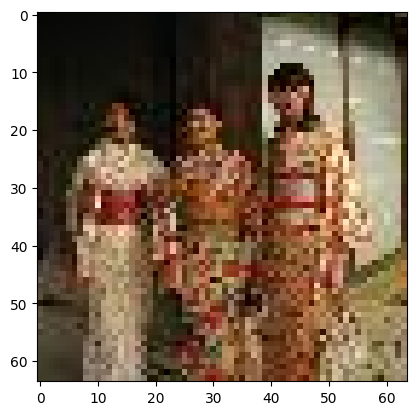

In [9]:
index = random.randint(0, 98179)
print("index =", index)
show_example(data_images[index], data_labels[index])

index = 2831
Label : 57


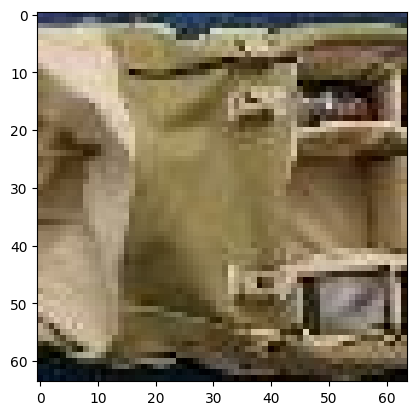

In [10]:
index = random.randint(0, 9832)
print("index =", index)
show_example(test_images[index], test_labels[index])

# Loading The Datset For Training Model

In [7]:
train_examples = 90000
validation_examples = 8179

class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.X = images
        self.Y = labels

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return (self.X[index], self.Y[index])


dataset = CustomDataset(data_images, data_labels)
train_set, validation_set = random_split(dataset, [train_examples, validation_examples])
test_set = CustomDataset(test_images, test_labels)

# Defining The Model

In [13]:
class Wide_ResNet(nn.Module):
    def __init__(self, width = 4, dropout = 0.33, num_classes=100):
        super().__init__()

        self.block0 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )

        self.block11 = nn.Sequential(
            nn.Conv2d(16, 16*width, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(16*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            nn.Conv2d(16*width, 16*width, kernel_size=3, padding=1, stride=1),
        )
        self.shortcut1 = nn.Conv2d(16, 16*width, kernel_size=1, stride=2)
        self.block12 = nn.Sequential(
            nn.BatchNorm2d(16*width),
            nn.ReLU(),
            nn.Conv2d(16*width, 16*width, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(16*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            nn.Conv2d(16*width, 16*width, kernel_size=3, padding=1, stride=1),
        )


        self.pre_block2 = nn.Sequential(
            nn.BatchNorm2d(16*width),
            nn.ReLU(),
        )
        self.block21 = nn.Sequential(
            nn.Conv2d(16*width, 32*width, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(32*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            nn.Conv2d(32*width, 32*width, kernel_size=3, padding=1, stride=1),
        )
        self.shortcut2 = nn.Conv2d(16*width, 32*width, kernel_size=1, stride=2)
        self.block22 = nn.Sequential(
            nn.BatchNorm2d(32*width),
            nn.ReLU(),
            nn.Conv2d(32*width, 32*width, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(32*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            nn.Conv2d(32*width, 32*width, kernel_size=3, padding=1, stride=1),
        )

        self.pre_block3 = nn.Sequential(
            nn.BatchNorm2d(32*width),
            nn.ReLU(),
        )
        self.block31 = nn.Sequential(
            nn.Conv2d(32*width, 64*width, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(64*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            nn.Conv2d(64*width, 64*width, kernel_size=3, padding=1, stride=1),
        )
        self.shortcut3 = nn.Conv2d(32*width, 64*width, kernel_size=1, stride=2)
        self.block32 = nn.Sequential(
            nn.BatchNorm2d(64*width),
            nn.ReLU(),
            nn.Conv2d(64*width, 64*width, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            nn.Conv2d(64*width, 64*width, kernel_size=3, padding=1, stride=1),
        )

        self.pool_block = nn.Sequential(
            nn.BatchNorm2d(64*width),
            nn.ReLU(),
            nn.AvgPool2d(8, 8), # Depending on Dataset this should change
        )

        self.fc = nn.Sequential(
            nn.Linear(64*width, 64*width),
            nn.ReLU(),
            nn.Dropout1d(dropout/2),
            nn.Linear(64*width, num_classes)
        )

    def forward(self, x):
        # x.shape = B x 3 x 64 x 64

        x = self.block0(x)
        # x.shape = B x 16 x 64 x 64

        x1 = self.block11(x)
        x2 = self.shortcut1(x)
        x3 = x1 + x2
        x4 = self.block12(x3)
        x = x3 + x4
        # x.shape = B x 16*width x 32 x 32

        x = self.pre_block2(x)
        x1 = self.block21(x)
        x2 = self.shortcut2(x)
        x3 = x1 + x2
        x4 = self.block22(x3)
        x = x3 + x4
        # x.shape = B x 32*width x 16 x 16

        x = self.pre_block3(x)
        x1 = self.block31(x)
        x2 = self.shortcut3(x)
        x3 = x1 + x2
        x4 = self.block32(x3)
        x = x3 + x4
        # x.shape = B x 64*width x 8 x 8

        x = self.pool_block(x)
        # x.shape = B x 64*width x 1 x 1

        x = torch.flatten(x, start_dim=1)
        # flatten all dimensions except batch (0th dim)
        # x.shape = B x 64*width

        x = self.fc(x)
        # x.shape = B x num_classes

        return x


# Helper Functions To Train And Test The Model

In [8]:
def validate(model, validation_loader, loss_fn):
  validation_loss = 0.0
  validation_correct = 0
  model.eval()
  with torch.no_grad(): 
    for j, (x_val, y_val) in enumerate(validation_loader):
      x_val = x_val.to(device)
      y_val = y_val.to(device)

      y_pred = model(x_val)
      loss = loss_fn(y_pred, y_val)

      predicted = torch.argmax(y_pred.data, dim=1)
      validation_correct += (predicted == y_val).sum().item()
      validation_loss += loss.item()

  return validation_loss, validation_correct

In [9]:
def test(model, test_loader):
  top1_correct = 0
  top5_correct = 0
  model.eval()
  with torch.no_grad(): 
    for j, (x_val, y_val) in enumerate(test_loader):
      x_val = x_val.to(device)
      y_val = y_val.to(device)

      y_pred = model(x_val)

      predicted = torch.argmax(y_pred.data, dim=1)
      top1_correct += (predicted == y_val).sum().item()

      val, ind = torch.topk(y_pred.data, 5, dim=1, largest=True, sorted=True)
      for i in range(5):
        top5_correct += (ind[ :, i] == y_val).sum().item()

  return top1_correct / 100, top5_correct / 100

In [10]:
def train(model, optimizer, scheduler, loss_fn, train_loader, validation_loader, test_loader, learning_rate, num_epochs):
  history = {'train_loss' : [], 'val_loss' : [], 'train_acc' : [], 'val_acc' : [], 'test_acc1' : [], 'test_acc5' : [], 'time' : []}
  optimizer = optimizer(model.parameters(), learning_rate, momentum=0.9, nesterov=True)
  scheduler = scheduler(optimizer, T_max=len(train_loader)*num_epochs)

  for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0.0
    train_correct = 0
    start = time.time()
    for i, (x_batch, y_batch) in enumerate(train_loader):
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)
    
      y_pred = model(x_batch)
      loss = loss_fn(y_pred, y_batch)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      scheduler.step()

      predicted = torch.argmax(y_pred.data, dim=1)
      train_correct += (predicted == y_batch).sum().item()
      train_loss += loss.item()
    end = time.time()
      
    # Validation Step
    validation_loss, validation_correct = validate(model, validation_loader, loss_fn)

    print("Epoch", epoch+1, "-\tTraining Loss :", train_loss/train_examples, "\tValidation Loss :", validation_loss/validation_examples)
    history['train_loss'].append(train_loss / train_examples)
    history['val_loss'].append(validation_loss / validation_examples)
    history['train_acc'].append(100 * train_correct / train_examples)
    history['val_acc'].append(100 * validation_correct / validation_examples)
    history['time'].append(end - start)

    # Test Step every 5th epoch
    if (epoch % 5) == 4:
      top1, top5 = test(model, test_loader)
      history['test_acc1'].append(top1)
      history['test_acc5'].append(top5)

      print("Training Accuracy =", 100 * train_correct / train_examples,
            "\tValidation Accuracy =", 100 * validation_correct / validation_examples,
            "\tTest Accuracy Top1 =", top1, "\tTest Accuracy Top5 =", top5)

  return history

In [11]:
def plot_loss(train_loss, val_loss):
  pyplot.plot(train_loss, '-b')
  pyplot.plot(val_loss, '-r')
  pyplot.xlabel('epoch')
  pyplot.ylabel('loss')
  pyplot.legend(['Training', 'Validation'])
  pyplot.title('Loss vs. No. of epochs')

In [12]:
def plot_acc(train_acc, val_acc):
  pyplot.plot(train_acc, '-b')
  pyplot.plot(val_acc, '-r')
  pyplot.xlabel('epoch')
  pyplot.ylabel('acurracy')
  pyplot.legend(['Training', 'Validation'])
  pyplot.title('Acurracy vs. No. of epochs')

In [13]:
def plot_test(test_acc1, test_acc5):
  x = range(5, 201, 5)
  x = x[ : len(test_acc1)]
  pyplot.plot(x, test_acc1, '-b')
  pyplot.plot(x, test_acc5, '-r')
  pyplot.xlabel('epoch')
  pyplot.ylabel('accuracy')
  pyplot.legend(['Top1 Accuracy', 'Top5 Accuracy'])
  pyplot.title('Accuracy vs. No. of epochs')

# Training The Model

In [20]:
model1 = Wide_ResNet(width=8, dropout=0.5, num_classes=200).to(device)
summary(model1, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             448
       BatchNorm2d-2           [-1, 16, 64, 64]              32
              ReLU-3           [-1, 16, 64, 64]               0
            Conv2d-4          [-1, 128, 32, 32]          18,560
       BatchNorm2d-5          [-1, 128, 32, 32]             256
              ReLU-6          [-1, 128, 32, 32]               0
         Dropout2d-7          [-1, 128, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]         147,584
            Conv2d-9          [-1, 128, 32, 32]           2,176
      BatchNorm2d-10          [-1, 128, 32, 32]             256
             ReLU-11          [-1, 128, 32, 32]               0
           Conv2d-12          [-1, 128, 32, 32]         147,584
      BatchNorm2d-13          [-1, 128, 32, 32]             256
             ReLU-14          [-1, 128,

In [21]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=256, shuffle=False)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False)

optimizer = torch.optim.SGD
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR
loss_fn = F.cross_entropy

history1 = train(model1, optimizer, scheduler, loss_fn, train_loader, validation_loader, test_loader, learning_rate=0.01, num_epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [01:09<56:35, 69.30s/it]

Epoch 1 -	Training Loss : 0.040158970499038694 	Validation Loss : 0.01907461268756949


  4%|▍         | 2/50 [02:08<50:33, 63.19s/it]

Epoch 2 -	Training Loss : 0.03808556948237949 	Validation Loss : 0.018466632426521103


  6%|▌         | 3/50 [03:09<48:39, 62.11s/it]

Epoch 3 -	Training Loss : 0.036504753165774874 	Validation Loss : 0.01815881220748422


  8%|▊         | 4/50 [04:08<46:46, 61.00s/it]

Epoch 4 -	Training Loss : 0.03522398736741808 	Validation Loss : 0.01630140787990508
Epoch 5 -	Training Loss : 0.03425913941860199 	Validation Loss : 0.016392434863272295


 10%|█         | 5/50 [05:08<45:39, 60.87s/it]

Training Accuracy = 9.12888888888889 	Validation Accuracy = 11.737376207360313 	Test Accuracy Top1 = 11.57 	Test Accuracy Top5 = 30.73


 12%|█▏        | 6/50 [06:08<44:19, 60.44s/it]

Epoch 6 -	Training Loss : 0.03347896161079407 	Validation Loss : 0.015255482830239298


 14%|█▍        | 7/50 [07:06<42:45, 59.66s/it]

Epoch 7 -	Training Loss : 0.032728110331959194 	Validation Loss : 0.01474050050668545


 16%|█▌        | 8/50 [08:05<41:38, 59.49s/it]

Epoch 8 -	Training Loss : 0.032024997928407455 	Validation Loss : 0.014219933171802226


 18%|█▊        | 9/50 [09:04<40:28, 59.22s/it]

Epoch 9 -	Training Loss : 0.031378425176938375 	Validation Loss : 0.01402598853390525
Epoch 10 -	Training Loss : 0.03086131779352824 	Validation Loss : 0.01352316086472123


 20%|██        | 10/50 [10:06<39:59, 60.00s/it]

Training Accuracy = 15.615555555555556 	Validation Accuracy = 23.670375351509964 	Test Accuracy Top1 = 23.87 	Test Accuracy Top5 = 50.3


 22%|██▏       | 11/50 [11:06<39:02, 60.06s/it]

Epoch 11 -	Training Loss : 0.030322537989086577 	Validation Loss : 0.013335963510507943


 24%|██▍       | 12/50 [12:08<38:24, 60.66s/it]

Epoch 12 -	Training Loss : 0.02989081575340695 	Validation Loss : 0.012958925471997871


 26%|██▌       | 13/50 [13:08<37:19, 60.51s/it]

Epoch 13 -	Training Loss : 0.029441525043381586 	Validation Loss : 0.013090953367498891


 28%|██▊       | 14/50 [14:09<36:27, 60.77s/it]

Epoch 14 -	Training Loss : 0.029072071817186143 	Validation Loss : 0.012379779575477094
Epoch 15 -	Training Loss : 0.02865474967956543 	Validation Loss : 0.01216241861267127


 30%|███       | 15/50 [15:11<35:33, 60.97s/it]

Training Accuracy = 20.504444444444445 	Validation Accuracy = 29.184496882259445 	Test Accuracy Top1 = 29.73 	Test Accuracy Top5 = 57.03


 32%|███▏      | 16/50 [16:10<34:15, 60.46s/it]

Epoch 16 -	Training Loss : 0.028307769884003534 	Validation Loss : 0.012025717141678112


 34%|███▍      | 17/50 [17:08<32:52, 59.78s/it]

Epoch 17 -	Training Loss : 0.02800038497183058 	Validation Loss : 0.011887320388950656


 36%|███▌      | 18/50 [18:08<31:47, 59.61s/it]

Epoch 18 -	Training Loss : 0.02766170150703854 	Validation Loss : 0.011704361399398601


 38%|███▊      | 19/50 [19:07<30:45, 59.55s/it]

Epoch 19 -	Training Loss : 0.02742106934653388 	Validation Loss : 0.011722039179458552
Epoch 20 -	Training Loss : 0.027099253106117247 	Validation Loss : 0.011390876239487908


 40%|████      | 20/50 [20:09<30:12, 60.43s/it]

Training Accuracy = 24.226666666666667 	Validation Accuracy = 33.023597016750216 	Test Accuracy Top1 = 34.09 	Test Accuracy Top5 = 61.1


 42%|████▏     | 21/50 [21:09<29:07, 60.27s/it]

Epoch 21 -	Training Loss : 0.02687048762374454 	Validation Loss : 0.01128160374892459


 44%|████▍     | 22/50 [22:08<27:54, 59.81s/it]

Epoch 22 -	Training Loss : 0.02664011863867442 	Validation Loss : 0.011225347050187465


 46%|████▌     | 23/50 [23:07<26:44, 59.41s/it]

Epoch 23 -	Training Loss : 0.026409056986702813 	Validation Loss : 0.011031745975241128


 48%|████▊     | 24/50 [24:05<25:40, 59.24s/it]

Epoch 24 -	Training Loss : 0.026145351224475435 	Validation Loss : 0.010801357575246445
Epoch 25 -	Training Loss : 0.02587962917221917 	Validation Loss : 0.010990839130444987


 50%|█████     | 25/50 [25:06<24:52, 59.70s/it]

Training Accuracy = 27.357777777777777 	Validation Accuracy = 35.13877002078494 	Test Accuracy Top1 = 35.54 	Test Accuracy Top5 = 63.24


 52%|█████▏    | 26/50 [26:05<23:46, 59.44s/it]

Epoch 26 -	Training Loss : 0.025664975590176053 	Validation Loss : 0.010783287901388052


 54%|█████▍    | 27/50 [27:03<22:36, 59.00s/it]

Epoch 27 -	Training Loss : 0.02541752179198795 	Validation Loss : 0.010588176910124281


 56%|█████▌    | 28/50 [28:01<21:34, 58.82s/it]

Epoch 28 -	Training Loss : 0.02527923657629225 	Validation Loss : 0.010427961927825073


 58%|█████▊    | 29/50 [29:00<20:33, 58.76s/it]

Epoch 29 -	Training Loss : 0.025146149571736654 	Validation Loss : 0.010412830408051773
Epoch 30 -	Training Loss : 0.024888592961099413 	Validation Loss : 0.010298590829748733


 60%|██████    | 30/50 [30:00<19:45, 59.28s/it]

Training Accuracy = 29.891111111111112 	Validation Accuracy = 38.47658637975302 	Test Accuracy Top1 = 39.37 	Test Accuracy Top5 = 66.62


 62%|██████▏   | 31/50 [31:01<18:51, 59.57s/it]

Epoch 31 -	Training Loss : 0.024656208075417414 	Validation Loss : 0.010367671031651076


 64%|██████▍   | 32/50 [32:00<17:52, 59.60s/it]

Epoch 32 -	Training Loss : 0.02449432440333896 	Validation Loss : 0.010175869362557455


 66%|██████▌   | 33/50 [33:00<16:55, 59.74s/it]

Epoch 33 -	Training Loss : 0.024337452991803486 	Validation Loss : 0.010088059353877986


 68%|██████▊   | 34/50 [33:59<15:48, 59.30s/it]

Epoch 34 -	Training Loss : 0.024237518186039395 	Validation Loss : 0.010093902489246723
Epoch 35 -	Training Loss : 0.024034028225474888 	Validation Loss : 0.010038300880462911


 70%|███████   | 35/50 [35:00<15:00, 60.01s/it]

Training Accuracy = 31.97222222222222 	Validation Accuracy = 39.54028609854505 	Test Accuracy Top1 = 39.99 	Test Accuracy Top5 = 67.42


 72%|███████▏  | 36/50 [35:59<13:55, 59.66s/it]

Epoch 36 -	Training Loss : 0.023981106490559047 	Validation Loss : 0.009921963253643886


 74%|███████▍  | 37/50 [36:59<12:56, 59.73s/it]

Epoch 37 -	Training Loss : 0.023817608613438075 	Validation Loss : 0.010049295215534397


 76%|███████▌  | 38/50 [37:57<11:50, 59.17s/it]

Epoch 38 -	Training Loss : 0.023688436290952894 	Validation Loss : 0.009820110568470878


 78%|███████▊  | 39/50 [38:56<10:51, 59.26s/it]

Epoch 39 -	Training Loss : 0.023476270439889695 	Validation Loss : 0.009745414368694402
Epoch 40 -	Training Loss : 0.023412180174721613 	Validation Loss : 0.009720777646153492


 80%|████████  | 40/50 [39:59<10:03, 60.32s/it]

Training Accuracy = 33.73888888888889 	Validation Accuracy = 41.1174960264091 	Test Accuracy Top1 = 41.96 	Test Accuracy Top5 = 68.91


 82%|████████▏ | 41/50 [40:58<09:00, 60.00s/it]

Epoch 41 -	Training Loss : 0.0233823263724645 	Validation Loss : 0.009691481835714747


 84%|████████▍ | 42/50 [41:59<08:00, 60.04s/it]

Epoch 42 -	Training Loss : 0.023263899154133266 	Validation Loss : 0.009667293558145213


 86%|████████▌ | 43/50 [42:59<07:00, 60.06s/it]

Epoch 43 -	Training Loss : 0.023258096135987175 	Validation Loss : 0.009643936845168666


 88%|████████▊ | 44/50 [43:59<06:00, 60.09s/it]

Epoch 44 -	Training Loss : 0.02320597830083635 	Validation Loss : 0.009637669634303073
Epoch 45 -	Training Loss : 0.023115470176272922 	Validation Loss : 0.009611009545774561


 90%|█████████ | 45/50 [45:02<05:04, 60.93s/it]

Training Accuracy = 34.61 	Validation Accuracy = 41.83885560581978 	Test Accuracy Top1 = 42.34 	Test Accuracy Top5 = 69.7


 92%|█████████▏| 46/50 [46:02<04:02, 60.63s/it]

Epoch 46 -	Training Loss : 0.023093035356203714 	Validation Loss : 0.009587893058682642


 94%|█████████▍| 47/50 [47:02<03:01, 60.60s/it]

Epoch 47 -	Training Loss : 0.02310706571208106 	Validation Loss : 0.009595190754349532


 96%|█████████▌| 48/50 [48:01<02:00, 60.04s/it]

Epoch 48 -	Training Loss : 0.02304929417769114 	Validation Loss : 0.009587792869826257


 98%|█████████▊| 49/50 [49:00<00:59, 59.61s/it]

Epoch 49 -	Training Loss : 0.02310710289478302 	Validation Loss : 0.009591403778818683
Epoch 50 -	Training Loss : 0.02301925179693434 	Validation Loss : 0.00960638916919511


100%|██████████| 50/50 [50:02<00:00, 60.05s/it]

Training Accuracy = 34.89333333333333 	Validation Accuracy = 41.92444064066512 	Test Accuracy Top1 = 42.39 	Test Accuracy Top5 = 69.61


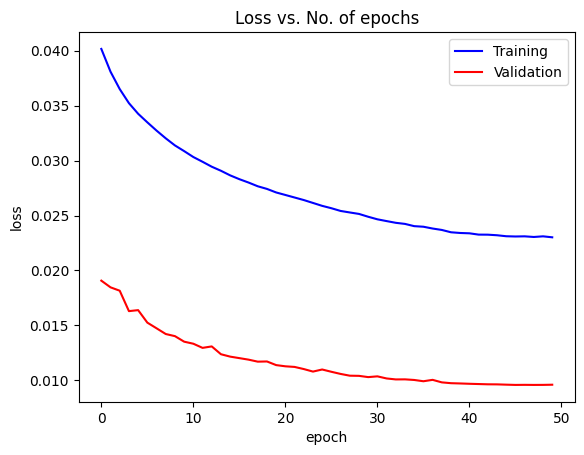

In [22]:
plot_loss(history1['train_loss'], history1['val_loss'])

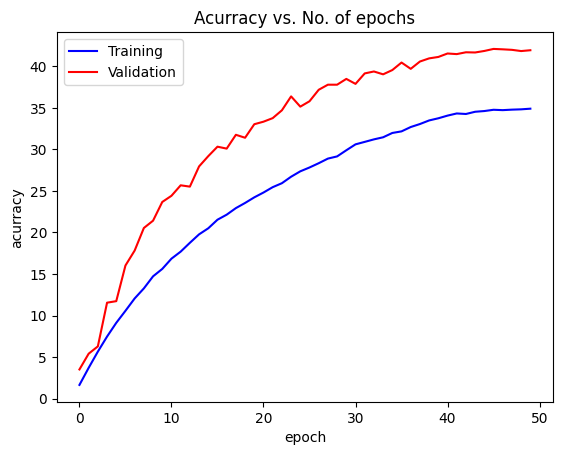

In [23]:
plot_acc(history1['train_acc'], history1['val_acc'])

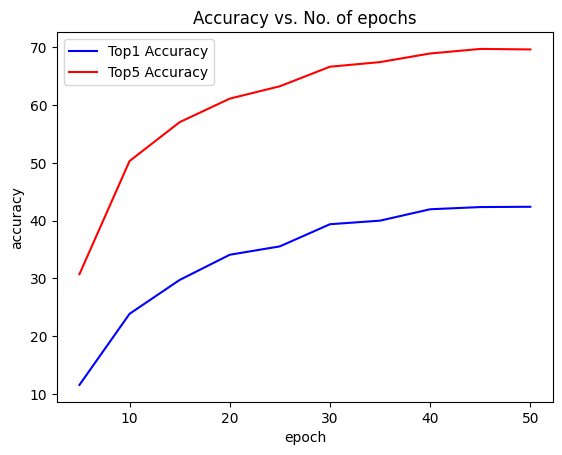

In [24]:
plot_test(history1['test_acc1'], history1['test_acc5'])

In [25]:
time_taken1 = np.array(history1['time'])
print("Average time per epoch for Wide_ResNet =", np.mean(time_taken1))

Average time per epoch for Wide_ResNet = 57.37523087024689


In [26]:
with open('wide_resnet_history_tiny_imagenet', 'wb') as f:
  pickle.dump(history1, f)

# Defining The Model

In [14]:
from AA_CNN import AttentionConv2d

In [15]:
class Wide_AAResNet(nn.Module):
    def __init__(self, width = 4, dropout = 0.33, num_classes=100):
        super().__init__()
        self.Nh = 1
        self.dv = 8

        self.block0 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )

        self.block11 = nn.Sequential(
            nn.Conv2d(16, 16*width, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(16*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            # nn.Conv2d(16*width, 16*width, kernel_size=3, padding=1, stride=1),
            AttentionConv2d(
                input_dim = 16*width,
                output_dim = 16*width,
                dk = 4*self.dv*width,
                dv = self.dv*width,
                num_heads = self.Nh,
                kernel_size = 3,
                padding = 1,
                device=device,
                height=32,
                width=32,
            ),
        )
        self.shortcut1 = nn.Conv2d(16, 16*width, kernel_size=1, stride=2)
        self.block12 = nn.Sequential(
            nn.BatchNorm2d(16*width),
            nn.ReLU(),
            nn.Conv2d(16*width, 16*width, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(16*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            # nn.Conv2d(16*width, 16*width, kernel_size=3, padding=1, stride=1),
            AttentionConv2d(
                input_dim = 16*width,
                output_dim = 16*width,
                dk = 4*self.dv*width,
                dv = self.dv*width,
                num_heads = self.Nh,
                kernel_size = 3,
                padding = 1,
                device=device,
                height=32,
                width=32,
            ),
        )


        self.pre_block2 = nn.Sequential(
            nn.BatchNorm2d(16*width),
            nn.ReLU(),
        )
        self.block21 = nn.Sequential(
            nn.Conv2d(16*width, 32*width, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(32*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            # nn.Conv2d(32*width, 32*width, kernel_size=3, padding=1, stride=1),
            AttentionConv2d(
                input_dim = 32*width,
                output_dim = 32*width,
                dk = 8*self.dv*width,
                dv = 2*self.dv*width,
                num_heads = 2*self.Nh,
                kernel_size = 3,
                padding = 1,
                device=device,
                height=16,
                width=16,
            ),
        )
        self.shortcut2 = nn.Conv2d(16*width, 32*width, kernel_size=1, stride=2)
        self.block22 = nn.Sequential(
            nn.BatchNorm2d(32*width),
            nn.ReLU(),
            nn.Conv2d(32*width, 32*width, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(32*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            # nn.Conv2d(32*width, 32*width, kernel_size=3, padding=1, stride=1),
            AttentionConv2d(
                input_dim = 32*width,
                output_dim = 32*width,
                dk = 8*self.dv*width,
                dv = 2*self.dv*width,
                num_heads = 2*self.Nh,
                kernel_size = 3,
                padding = 1,
                device=device,
                height=16,
                width=16,
            ),
        )

        self.pre_block3 = nn.Sequential(
            nn.BatchNorm2d(32*width),
            nn.ReLU(),
        )
        self.block31 = nn.Sequential(
            nn.Conv2d(32*width, 64*width, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(64*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            # nn.Conv2d(64*width, 64*width, kernel_size=3, padding=1, stride=1),
            AttentionConv2d(
                input_dim = 64*width,
                output_dim = 64*width,
                dk = 16*self.dv*width,
                dv = 4*self.dv*width,
                num_heads = 4*self.Nh,
                kernel_size = 3,
                padding = 1,
                device=device,
                height=8,
                width=8,
            ),
        )
        self.shortcut3 = nn.Conv2d(32*width, 64*width, kernel_size=1, stride=2)
        self.block32 = nn.Sequential(
            nn.BatchNorm2d(64*width),
            nn.ReLU(),
            nn.Conv2d(64*width, 64*width, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            # nn.Conv2d(64*width, 64*width, kernel_size=3, padding=1, stride=1),
            AttentionConv2d(
                input_dim = 64*width,
                output_dim = 64*width,
                dk = 16*self.dv*width,
                dv = 4*self.dv*width,
                num_heads = 4*self.Nh,
                kernel_size = 3,
                padding = 1,
                device=device,
                height=8,
                width=8,
            ),
        )

        self.pool_block = nn.Sequential(
            nn.BatchNorm2d(64*width),
            nn.ReLU(),
            nn.AvgPool2d(8, 8),
        )

        self.fc = nn.Sequential(
            nn.Linear(64*width, 64*width),
            nn.ReLU(),
            nn.Dropout1d(dropout/2),
            nn.Linear(64*width, num_classes)
        )

    def forward(self, x):
        # x.shape = B x 3 x 64 x 64

        x = self.block0(x)
        # x.shape = B x 16 x 64 x 64

        x1 = self.block11(x)
        x2 = self.shortcut1(x)
        x3 = x1 + x2
        x4 = self.block12(x3)
        x = x4 + x3
        # x.shape = B x 16*width x 32 x 32

        x = self.pre_block2(x)
        x1 = self.block21(x)
        x2 = self.shortcut2(x)
        x3 = x1 + x2
        x4 = self.block22(x3)
        x = x4 + x3
        # x.shape = B x 32*width x 16 x 16

        x = self.pre_block3(x)
        x1 = self.block31(x)
        x2 = self.shortcut3(x)
        x3 = x1 + x2
        x4 = self.block32(x3)
        x = x4 + x3
        # x.shape = B x 64*width x 8 x 8

        x = self.pool_block(x)
        # x.shape = B x 64*width x 1 x 1

        x = torch.flatten(x, start_dim=1)
        # flatten all dimensions except batch (0th dim)
        # x.shape = B x 64*width

        x = self.fc(x)
        # x.shape = B x num_classes

        return x

# Training The Model

In [36]:
model2 = Wide_AAResNet(width=8, dropout=0.5, num_classes=200).to(device)
summary(model2, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             448
       BatchNorm2d-2           [-1, 16, 64, 64]              32
              ReLU-3           [-1, 16, 64, 64]               0
            Conv2d-4          [-1, 128, 32, 32]          18,560
       BatchNorm2d-5          [-1, 128, 32, 32]             256
              ReLU-6          [-1, 128, 32, 32]               0
         Dropout2d-7          [-1, 128, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          73,792
            Conv2d-9          [-1, 576, 32, 32]          74,304
          Softmax-10        [-1, 1, 1024, 1024]               0
           Conv2d-11           [-1, 64, 32, 32]           4,160
  AttentionConv2d-12          [-1, 128, 32, 32]               0
           Conv2d-13          [-1, 128, 32, 32]           2,176
      BatchNorm2d-14          [-1, 128,

In [20]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=256, shuffle=False)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False)

optimizer = torch.optim.SGD
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR
loss_fn = F.cross_entropy

history2 = train(model2, optimizer, scheduler, loss_fn, train_loader, validation_loader, test_loader, learning_rate=0.01, num_epochs=50)

  2%|▏         | 1/50 [02:15<1:50:32, 135.36s/it]

Epoch 1 -	Training Loss : 0.039590798309114245 	Validation Loss : 0.018928176515156898


  4%|▍         | 2/50 [04:23<1:44:56, 131.17s/it]

Epoch 2 -	Training Loss : 0.036964506997002496 	Validation Loss : 0.017101907106290632


  6%|▌         | 3/50 [06:31<1:41:42, 129.85s/it]

Epoch 3 -	Training Loss : 0.034945411507288617 	Validation Loss : 0.01577300138644913


  8%|▊         | 4/50 [08:40<1:39:05, 129.24s/it]

Epoch 4 -	Training Loss : 0.03318495735062493 	Validation Loss : 0.016451685684265666
Epoch 5 -	Training Loss : 0.03184288524256812 	Validation Loss : 0.014114031976498577


 10%|█         | 5/50 [10:52<1:37:46, 130.37s/it]

Training Accuracy = 14.008888888888889 	Validation Accuracy = 20.100256755104535 	Test Accuracy Top1 = 20.65 	Test Accuracy Top5 = 45.87


 12%|█▏        | 6/50 [13:00<1:34:54, 129.41s/it]

Epoch 6 -	Training Loss : 0.030816973951127796 	Validation Loss : 0.014810596472594074


 14%|█▍        | 7/50 [15:09<1:32:37, 129.25s/it]

Epoch 7 -	Training Loss : 0.029991539306110804 	Validation Loss : 0.01861115011496683


 16%|█▌        | 8/50 [17:16<1:30:05, 128.71s/it]

Epoch 8 -	Training Loss : 0.029249279734823438 	Validation Loss : 0.015524161125777302


 18%|█▊        | 9/50 [19:24<1:27:44, 128.40s/it]

Epoch 9 -	Training Loss : 0.0285515984137853 	Validation Loss : 0.012738850606742735
Epoch 10 -	Training Loss : 0.027995385914378695 	Validation Loss : 0.012348625884106812


 20%|██        | 10/50 [21:35<1:26:10, 129.25s/it]

Training Accuracy = 22.192222222222224 	Validation Accuracy = 28.279740799608753 	Test Accuracy Top1 = 28.72 	Test Accuracy Top5 = 54.54


 22%|██▏       | 11/50 [23:45<1:24:13, 129.58s/it]

Epoch 11 -	Training Loss : 0.027410451436042784 	Validation Loss : 0.012376781751159527


 24%|██▍       | 12/50 [25:53<1:21:42, 129.00s/it]

Epoch 12 -	Training Loss : 0.027031512337260775 	Validation Loss : 0.011866183338662


 26%|██▌       | 13/50 [28:00<1:19:13, 128.49s/it]

Epoch 13 -	Training Loss : 0.02658358742396037 	Validation Loss : 0.011580964495491786


 28%|██▊       | 14/50 [30:09<1:17:03, 128.44s/it]

Epoch 14 -	Training Loss : 0.026106479501724244 	Validation Loss : 0.01131646008461783
Epoch 15 -	Training Loss : 0.02568913338714176 	Validation Loss : 0.01110668152639956


 30%|███       | 15/50 [32:20<1:15:27, 129.37s/it]

Training Accuracy = 27.913333333333334 	Validation Accuracy = 34.14842890328891 	Test Accuracy Top1 = 35.1 	Test Accuracy Top5 = 61.57


 32%|███▏      | 16/50 [34:27<1:12:54, 128.66s/it]

Epoch 16 -	Training Loss : 0.02529055729707082 	Validation Loss : 0.011036179791250064


 34%|███▍      | 17/50 [36:34<1:10:30, 128.21s/it]

Epoch 17 -	Training Loss : 0.0249609415213267 	Validation Loss : 0.011508092479143797


 36%|███▌      | 18/50 [38:42<1:08:20, 128.14s/it]

Epoch 18 -	Training Loss : 0.024608951592445374 	Validation Loss : 0.011007828414549468


 38%|███▊      | 19/50 [40:48<1:05:48, 127.38s/it]

Epoch 19 -	Training Loss : 0.024256471557087367 	Validation Loss : 0.010478504684388542
Epoch 20 -	Training Loss : 0.02388476022614373 	Validation Loss : 0.010455406386952248


 40%|████      | 20/50 [42:59<1:04:10, 128.36s/it]

Training Accuracy = 32.29555555555555 	Validation Accuracy = 37.54737743000367 	Test Accuracy Top1 = 37.64 	Test Accuracy Top5 = 64.18


 42%|████▏     | 21/50 [45:03<1:01:24, 127.04s/it]

Epoch 21 -	Training Loss : 0.023701280670695834 	Validation Loss : 0.010778131542119526


 44%|████▍     | 22/50 [47:11<59:25, 127.33s/it]  

Epoch 22 -	Training Loss : 0.02334741859436035 	Validation Loss : 0.010175260475495433


 46%|████▌     | 23/50 [49:18<57:22, 127.49s/it]

Epoch 23 -	Training Loss : 0.02309947923289405 	Validation Loss : 0.01012610208581546


 48%|████▊     | 24/50 [51:20<54:30, 125.79s/it]

Epoch 24 -	Training Loss : 0.022736767440372042 	Validation Loss : 0.010417708296518714
Epoch 25 -	Training Loss : 0.022380367263158164 	Validation Loss : 0.00992383378571411


 50%|█████     | 25/50 [53:33<53:14, 127.79s/it]

Training Accuracy = 36.29333333333334 	Validation Accuracy = 39.748135468883724 	Test Accuracy Top1 = 40.73 	Test Accuracy Top5 = 66.88


 52%|█████▏    | 26/50 [55:38<50:52, 127.18s/it]

Epoch 26 -	Training Loss : 0.022161803327666388 	Validation Loss : 0.009979881653212615


 54%|█████▍    | 27/50 [57:41<48:14, 125.84s/it]

Epoch 27 -	Training Loss : 0.021831837402449712 	Validation Loss : 0.009957756094251027


 56%|█████▌    | 28/50 [59:48<46:16, 126.22s/it]

Epoch 28 -	Training Loss : 0.021663094470236035 	Validation Loss : 0.009859499976226586


 58%|█████▊    | 29/50 [1:02:02<44:57, 128.47s/it]

Epoch 29 -	Training Loss : 0.02133528877099355 	Validation Loss : 0.009819323516064014
Epoch 30 -	Training Loss : 0.021139858786265054 	Validation Loss : 0.009722108085372072


 60%|██████    | 30/50 [1:04:15<43:16, 129.83s/it]

Training Accuracy = 39.69 	Validation Accuracy = 41.3375718302971 	Test Accuracy Top1 = 41.19 	Test Accuracy Top5 = 67.04


 62%|██████▏   | 31/50 [1:06:23<40:55, 129.21s/it]

Epoch 31 -	Training Loss : 0.02081484538714091 	Validation Loss : 0.009936253560144695


 64%|██████▍   | 32/50 [1:08:30<38:33, 128.50s/it]

Epoch 32 -	Training Loss : 0.020578890217675103 	Validation Loss : 0.009616379487746239


 66%|██████▌   | 33/50 [1:10:36<36:14, 127.94s/it]

Epoch 33 -	Training Loss : 0.020361865441004434 	Validation Loss : 0.00966887043221741


 68%|██████▊   | 34/50 [1:12:45<34:09, 128.07s/it]

Epoch 34 -	Training Loss : 0.020134494113922118 	Validation Loss : 0.009846565148870933
Epoch 35 -	Training Loss : 0.019858352745903862 	Validation Loss : 0.009737921338280163


 70%|███████   | 35/50 [1:14:58<32:24, 129.63s/it]

Training Accuracy = 43.56 	Validation Accuracy = 40.98300525736643 	Test Accuracy Top1 = 41.45 	Test Accuracy Top5 = 67.28


 72%|███████▏  | 36/50 [1:17:12<30:35, 131.14s/it]

Epoch 36 -	Training Loss : 0.019738536332713233 	Validation Loss : 0.009554498395909305


 74%|███████▍  | 37/50 [1:19:23<28:21, 130.87s/it]

Epoch 37 -	Training Loss : 0.019448779820071326 	Validation Loss : 0.009514733943106682


 76%|███████▌  | 38/50 [1:21:31<26:00, 130.04s/it]

Epoch 38 -	Training Loss : 0.01936146686077118 	Validation Loss : 0.009529054390799666


 78%|███████▊  | 39/50 [1:23:40<23:47, 129.76s/it]

Epoch 39 -	Training Loss : 0.019046856858995227 	Validation Loss : 0.009538534058089186
Epoch 40 -	Training Loss : 0.018979689905378554 	Validation Loss : 0.009538253954882609


 80%|████████  | 40/50 [1:25:54<21:50, 131.05s/it]

Training Accuracy = 46.13666666666666 	Validation Accuracy = 42.376818681990464 	Test Accuracy Top1 = 42.04 	Test Accuracy Top5 = 68.18


 82%|████████▏ | 41/50 [1:28:02<19:31, 130.19s/it]

Epoch 41 -	Training Loss : 0.018819777631759644 	Validation Loss : 0.009487052639505219


 84%|████████▍ | 42/50 [1:30:11<17:17, 129.68s/it]

Epoch 42 -	Training Loss : 0.01869016365740034 	Validation Loss : 0.009514953326677573


 86%|████████▌ | 43/50 [1:32:21<15:09, 129.95s/it]

Epoch 43 -	Training Loss : 0.018708483052253724 	Validation Loss : 0.00950991563742195


 88%|████████▊ | 44/50 [1:34:29<12:55, 129.32s/it]

Epoch 44 -	Training Loss : 0.018537605028682284 	Validation Loss : 0.009490801253518756
Epoch 45 -	Training Loss : 0.01846299921936459 	Validation Loss : 0.009481081885046212


 90%|█████████ | 45/50 [1:36:52<11:06, 133.31s/it]

Training Accuracy = 47.76 	Validation Accuracy = 42.645800220075806 	Test Accuracy Top1 = 42.28 	Test Accuracy Top5 = 68.44


 92%|█████████▏| 46/50 [1:38:59<08:45, 131.42s/it]

Epoch 46 -	Training Loss : 0.018408150152365365 	Validation Loss : 0.009473611329350703


 94%|█████████▍| 47/50 [1:41:05<06:30, 130.00s/it]

Epoch 47 -	Training Loss : 0.01842448283963733 	Validation Loss : 0.009480375316035471


 96%|█████████▌| 48/50 [1:43:13<04:18, 129.26s/it]

Epoch 48 -	Training Loss : 0.018366874066988628 	Validation Loss : 0.009494773594466467


 98%|█████████▊| 49/50 [1:45:23<02:09, 129.50s/it]

Epoch 49 -	Training Loss : 0.018452668845653535 	Validation Loss : 0.009466730363358202
Epoch 50 -	Training Loss : 0.01827311545477973 	Validation Loss : 0.009479156988059735


100%|██████████| 50/50 [1:47:35<00:00, 129.11s/it]

Training Accuracy = 48.388888888888886 	Validation Accuracy = 43.024819660105145 	Test Accuracy Top1 = 42.18 	Test Accuracy Top5 = 68.44


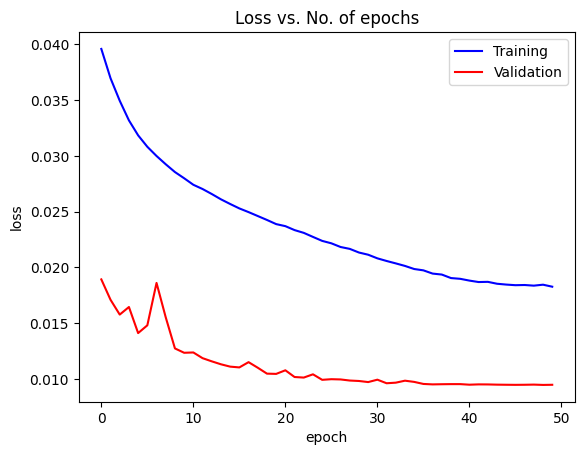

In [21]:
plot_loss(history2['train_loss'], history2['val_loss'])

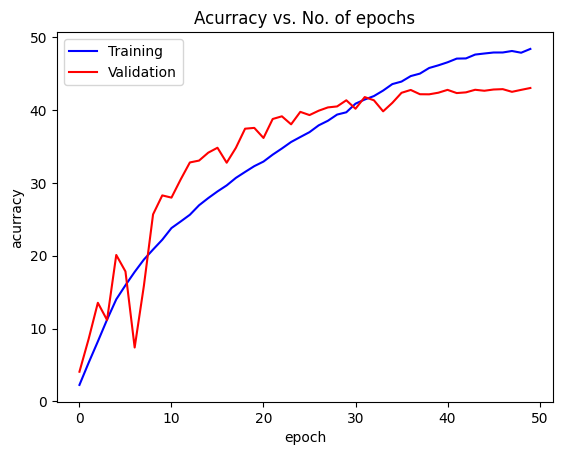

In [22]:
plot_acc(history2['train_acc'], history2['val_acc'])

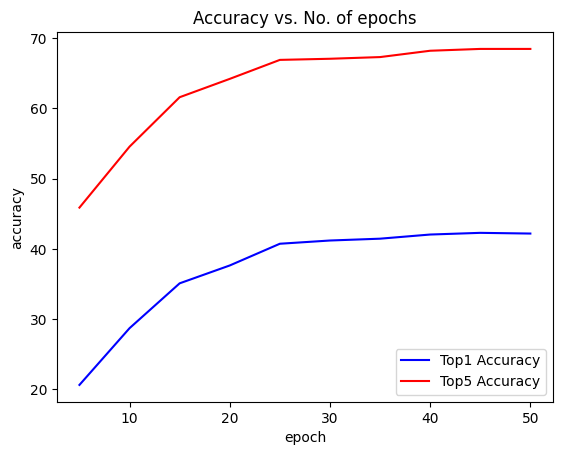

In [23]:
plot_test(history2['test_acc1'], history2['test_acc5'])

In [24]:
time_taken2 = np.array(history2['time'])
print("Average time per epoch for Wide_AAResNet =", np.mean(time_taken2))

Average time per epoch for Wide_AAResNet = 124.09068312644959


In [25]:
with open('wide_aaresnet_history_tiny_imagenet', 'wb') as f:
  pickle.dump(history2, f)

# Defning The Model

In [26]:
from AA_CNN import LinearAttentionConv2d

In [27]:
class Wide_LAAResNet(nn.Module):
    def __init__(self, width = 4, dropout = 0.33, num_classes=100):
        super().__init__()
        self.Nh = 1
        self.dv = 8

        self.block0 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )

        self.block11 = nn.Sequential(
            nn.Conv2d(16, 16*width, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(16*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            # nn.Conv2d(16*width, 16*width, kernel_size=3, padding=1, stride=1),
            LinearAttentionConv2d(
                input_dim = 16*width,
                output_dim = 16*width,
                dk = 4*self.dv*width,
                dv = self.dv*width,
                num_heads = self.Nh,
                kernel_size = 3,
                padding = 1,
                device=device,
                height=32,
                width=32,
            ),
        )
        self.shortcut1 = nn.Conv2d(16, 16*width, kernel_size=1, stride=2)
        self.block12 = nn.Sequential(
            nn.BatchNorm2d(16*width),
            nn.ReLU(),
            nn.Conv2d(16*width, 16*width, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(16*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            nn.Conv2d(16*width, 16*width, kernel_size=3, padding=1, stride=1),
            LinearAttentionConv2d(
                input_dim = 16*width,
                output_dim = 16*width,
                dk = 4*self.dv*width,
                dv = self.dv*width,
                num_heads = self.Nh,
                kernel_size = 3,
                padding = 1,
                device=device,
                height=32,
                width=32,
            ),
        )


        self.pre_block2 = nn.Sequential(
            nn.BatchNorm2d(16*width),
            nn.ReLU(),
        )
        self.block21 = nn.Sequential(
            nn.Conv2d(16*width, 32*width, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(32*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            # nn.Conv2d(32*width, 32*width, kernel_size=3, padding=1, stride=1),
            LinearAttentionConv2d(
                input_dim = 32*width,
                output_dim = 32*width,
                dk = 8*self.dv*width,
                dv = 2*self.dv*width,
                num_heads = 2*self.Nh,
                kernel_size = 3,
                padding = 1,
                device=device,
                height=16,
                width=16,
            ),
        )
        self.shortcut2 = nn.Conv2d(16*width, 32*width, kernel_size=1, stride=2)
        self.block22 = nn.Sequential(
            nn.BatchNorm2d(32*width),
            nn.ReLU(),
            nn.Conv2d(32*width, 32*width, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(32*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            # nn.Conv2d(32*width, 32*width, kernel_size=3, padding=1, stride=1),
            LinearAttentionConv2d(
                input_dim = 32*width,
                output_dim = 32*width,
                dk = 8*self.dv*width,
                dv = 2*self.dv*width,
                num_heads = 2*self.Nh,
                kernel_size = 3,
                padding = 1,
                device=device,
                height=16,
                width=16,
            ),
        )

        self.pre_block3 = nn.Sequential(
            nn.BatchNorm2d(32*width),
            nn.ReLU(),
        )
        self.block31 = nn.Sequential(
            nn.Conv2d(32*width, 64*width, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(64*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            # nn.Conv2d(64*width, 64*width, kernel_size=3, padding=1, stride=1),
            LinearAttentionConv2d(
                input_dim = 64*width,
                output_dim = 64*width,
                dk = 16*self.dv*width,
                dv = 4*self.dv*width,
                num_heads = 4*self.Nh,
                kernel_size = 3,
                padding = 1,
                device=device,
                height=8,
                width=8,
            ),
        )
        self.shortcut3 = nn.Conv2d(32*width, 64*width, kernel_size=1, stride=2)
        self.block32 = nn.Sequential(
            nn.BatchNorm2d(64*width),
            nn.ReLU(),
            nn.Conv2d(64*width, 64*width, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            # nn.Conv2d(64*width, 64*width, kernel_size=3, padding=1, stride=1),
            LinearAttentionConv2d(
                input_dim = 64*width,
                output_dim = 64*width,
                dk = 16*self.dv*width,
                dv = 4*self.dv*width,
                num_heads = 4*self.Nh,
                kernel_size = 3,
                padding = 1,
                device=device,
                height=8,
                width=8,
            ),
        )

        self.pool_block = nn.Sequential(
            nn.BatchNorm2d(64*width),
            nn.ReLU(),
            nn.AvgPool2d(8, 8),
        )

        self.fc = nn.Sequential(
            nn.Linear(64*width, 64*width),
            nn.ReLU(),
            nn.Dropout1d(dropout/2),
            nn.Linear(64*width, num_classes)
        )

    def forward(self, x):
        # x.shape = B x 3 x 64 x 64

        x = self.block0(x)
        # x.shape = B x 16 x 64 x 64

        x1 = self.block11(x)
        x2 = self.shortcut1(x)
        x3 = x1 + x2
        x4 = self.block12(x3)
        x = x4 + x3
        # x.shape = B x 16*width x 32 x 32

        x = self.pre_block2(x)
        x1 = self.block21(x)
        x2 = self.shortcut2(x)
        x3 = x1 + x2
        x4 = self.block22(x3)
        x = x4 + x3
        # x.shape = B x 32*width x 16 x 16

        x = self.pre_block3(x)
        x1 = self.block31(x)
        x2 = self.shortcut3(x)
        x3 = x1 + x2
        x4 = self.block32(x3)
        x = x4 + x3
        # x.shape = B x 64*width x 8 x 8

        x = self.pool_block(x)
        # x.shape = B x 64*width x 1 x 1

        x = torch.flatten(x, start_dim=1)
        # flatten all dimensions except batch (0th dim)
        # x.shape = B x 64*width

        x = self.fc(x)
        # x.shape = B x num_classes

        return x

# Training The Model

In [37]:
model3 = Wide_LAAResNet(width=8, dropout=0.5, num_classes=200).to(device)
summary(model3, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             448
       BatchNorm2d-2           [-1, 16, 64, 64]              32
              ReLU-3           [-1, 16, 64, 64]               0
            Conv2d-4          [-1, 128, 32, 32]          18,560
       BatchNorm2d-5          [-1, 128, 32, 32]             256
              ReLU-6          [-1, 128, 32, 32]               0
         Dropout2d-7          [-1, 128, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          73,792
            Conv2d-9          [-1, 576, 32, 32]          74,304
          Softmax-10         [-1, 1, 256, 1024]               0
          Softmax-11         [-1, 1, 256, 1024]               0
           Conv2d-12           [-1, 64, 32, 32]           4,160
LinearAttentionConv2d-13          [-1, 128, 32, 32]               0
           Conv2d-14          [-1, 

In [29]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=256, shuffle=False)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False)

optimizer = torch.optim.SGD
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR
loss_fn = F.cross_entropy

history3 = train(model3, optimizer, scheduler, loss_fn, train_loader, validation_loader, test_loader, learning_rate=0.01, num_epochs=50)

  2%|▏         | 1/50 [01:50<1:30:06, 110.34s/it]

Epoch 1 -	Training Loss : 0.039696785736083984 	Validation Loss : 0.01849177041399492


  4%|▍         | 2/50 [03:42<1:29:00, 111.27s/it]

Epoch 2 -	Training Loss : 0.03722550304200914 	Validation Loss : 0.01746679305563872


  6%|▌         | 3/50 [05:35<1:27:57, 112.29s/it]

Epoch 3 -	Training Loss : 0.03561690775023566 	Validation Loss : 0.017345274087924772


  8%|▊         | 4/50 [07:33<1:27:42, 114.40s/it]

Epoch 4 -	Training Loss : 0.03423409712579515 	Validation Loss : 0.015736986014061472
Epoch 5 -	Training Loss : 0.03307730290359921 	Validation Loss : 0.01589001960954947


 10%|█         | 5/50 [09:42<1:29:38, 119.53s/it]

Training Accuracy = 11.448888888888888 	Validation Accuracy = 13.742511309451032 	Test Accuracy Top1 = 14.38 	Test Accuracy Top5 = 34.56


 12%|█▏        | 6/50 [11:43<1:28:14, 120.34s/it]

Epoch 6 -	Training Loss : 0.032138429964913263 	Validation Loss : 0.014589461972448496


 14%|█▍        | 7/50 [13:48<1:27:11, 121.65s/it]

Epoch 7 -	Training Loss : 0.031316551536983914 	Validation Loss : 0.014696456645896082


 16%|█▌        | 8/50 [15:54<1:26:05, 123.00s/it]

Epoch 8 -	Training Loss : 0.030568771272235448 	Validation Loss : 0.01351224628429364


 18%|█▊        | 9/50 [17:59<1:24:34, 123.77s/it]

Epoch 9 -	Training Loss : 0.029959576376279193 	Validation Loss : 0.013019739029270205
Epoch 10 -	Training Loss : 0.029495021465089585 	Validation Loss : 0.013313336890664074


 20%|██        | 10/50 [20:10<1:24:02, 126.06s/it]

Training Accuracy = 18.685555555555556 	Validation Accuracy = 23.474752414720626 	Test Accuracy Top1 = 23.77 	Test Accuracy Top5 = 50.15


 22%|██▏       | 11/50 [22:16<1:21:52, 125.97s/it]

Epoch 11 -	Training Loss : 0.02891007914543152 	Validation Loss : 0.012797729414298463


 24%|██▍       | 12/50 [24:20<1:19:27, 125.45s/it]

Epoch 12 -	Training Loss : 0.028520897873242697 	Validation Loss : 0.01233823323602533


 26%|██▌       | 13/50 [26:27<1:17:38, 125.91s/it]

Epoch 13 -	Training Loss : 0.028171952403916255 	Validation Loss : 0.012034733468300703


 28%|██▊       | 14/50 [28:33<1:15:33, 125.92s/it]

Epoch 14 -	Training Loss : 0.027781912634107803 	Validation Loss : 0.012158186690179741
Epoch 15 -	Training Loss : 0.0274298526207606 	Validation Loss : 0.011669375054307781


 30%|███       | 15/50 [30:41<1:13:45, 126.44s/it]

Training Accuracy = 23.43777777777778 	Validation Accuracy = 32.265558136691524 	Test Accuracy Top1 = 32.53 	Test Accuracy Top5 = 60.09


 32%|███▏      | 16/50 [32:45<1:11:19, 125.88s/it]

Epoch 16 -	Training Loss : 0.02709613563749525 	Validation Loss : 0.01150113720957407


 34%|███▍      | 17/50 [34:50<1:08:57, 125.38s/it]

Epoch 17 -	Training Loss : 0.026811616407500374 	Validation Loss : 0.011325820790393558


 36%|███▌      | 18/50 [36:56<1:07:00, 125.64s/it]

Epoch 18 -	Training Loss : 0.026485009712643094 	Validation Loss : 0.01117787706282075


 38%|███▊      | 19/50 [39:03<1:05:05, 125.98s/it]

Epoch 19 -	Training Loss : 0.026146959596210054 	Validation Loss : 0.010967132149997295
Epoch 20 -	Training Loss : 0.025934938542048137 	Validation Loss : 0.0109847394451417


 40%|████      | 20/50 [41:13<1:03:38, 127.28s/it]

Training Accuracy = 27.026666666666667 	Validation Accuracy = 35.21212862208094 	Test Accuracy Top1 = 35.43 	Test Accuracy Top5 = 62.6


 42%|████▏     | 21/50 [43:19<1:01:18, 126.84s/it]

Epoch 21 -	Training Loss : 0.025624738213751053 	Validation Loss : 0.011668654376653896


 44%|████▍     | 22/50 [45:23<58:52, 126.17s/it]  

Epoch 22 -	Training Loss : 0.02545696997642517 	Validation Loss : 0.010888923860030588


 46%|████▌     | 23/50 [47:25<56:12, 124.89s/it]

Epoch 23 -	Training Loss : 0.02516015837457445 	Validation Loss : 0.010576640616595447


 48%|████▊     | 24/50 [49:30<54:01, 124.67s/it]

Epoch 24 -	Training Loss : 0.024995454772313436 	Validation Loss : 0.010723191902710065
Epoch 25 -	Training Loss : 0.02473729598257277 	Validation Loss : 0.010586761993947364


 50%|█████     | 25/50 [51:36<52:11, 125.25s/it]

Training Accuracy = 30.19333333333333 	Validation Accuracy = 36.459224844112974 	Test Accuracy Top1 = 36.62 	Test Accuracy Top5 = 64.71


 52%|█████▏    | 26/50 [53:41<50:05, 125.23s/it]

Epoch 26 -	Training Loss : 0.02452708113723331 	Validation Loss : 0.010494273017009264


 54%|█████▍    | 27/50 [55:47<48:00, 125.24s/it]

Epoch 27 -	Training Loss : 0.024358947303560044 	Validation Loss : 0.01024009971837861


 56%|█████▌    | 28/50 [57:53<46:01, 125.54s/it]

Epoch 28 -	Training Loss : 0.0241440067158805 	Validation Loss : 0.010043314841545973


 58%|█████▊    | 29/50 [59:59<44:01, 125.78s/it]

Epoch 29 -	Training Loss : 0.024032251397768656 	Validation Loss : 0.00998267096694254
Epoch 30 -	Training Loss : 0.02384581448237101 	Validation Loss : 0.009959776516079625


 60%|██████    | 30/50 [1:02:10<42:25, 127.28s/it]

Training Accuracy = 32.48222222222222 	Validation Accuracy = 39.9926641398704 	Test Accuracy Top1 = 40.36 	Test Accuracy Top5 = 67.62


 62%|██████▏   | 31/50 [1:04:15<40:04, 126.53s/it]

Epoch 31 -	Training Loss : 0.02372281572818756 	Validation Loss : 0.009843641628130591


 64%|██████▍   | 32/50 [1:06:20<37:51, 126.17s/it]

Epoch 32 -	Training Loss : 0.023483146203888788 	Validation Loss : 0.009808498338959826


 66%|██████▌   | 33/50 [1:08:25<35:40, 125.92s/it]

Epoch 33 -	Training Loss : 0.02342986747423808 	Validation Loss : 0.009816032208648955


 68%|██████▊   | 34/50 [1:10:31<33:32, 125.76s/it]

Epoch 34 -	Training Loss : 0.023226682453685338 	Validation Loss : 0.009607067637519916
Epoch 35 -	Training Loss : 0.023071522008048163 	Validation Loss : 0.00954208751225591


 70%|███████   | 35/50 [1:12:41<31:46, 127.07s/it]

Training Accuracy = 34.45444444444445 	Validation Accuracy = 42.10783714390512 	Test Accuracy Top1 = 42.12 	Test Accuracy Top5 = 69.27


 72%|███████▏  | 36/50 [1:14:47<29:33, 126.67s/it]

Epoch 36 -	Training Loss : 0.02287718913290236 	Validation Loss : 0.00958052056388701


 74%|███████▍  | 37/50 [1:16:52<27:20, 126.18s/it]

Epoch 37 -	Training Loss : 0.022784383885065713 	Validation Loss : 0.009449025910966684


 76%|███████▌  | 38/50 [1:18:57<25:11, 125.93s/it]

Epoch 38 -	Training Loss : 0.022822427950965035 	Validation Loss : 0.009504428512091916


 78%|███████▊  | 39/50 [1:21:02<23:00, 125.50s/it]

Epoch 39 -	Training Loss : 0.022650287085109286 	Validation Loss : 0.009495250898026096
Epoch 40 -	Training Loss : 0.022469311330053542 	Validation Loss : 0.00936108472688607


 80%|████████  | 40/50 [1:23:11<21:05, 126.57s/it]

Training Accuracy = 36.284444444444446 	Validation Accuracy = 42.951461058809144 	Test Accuracy Top1 = 43.14 	Test Accuracy Top5 = 70.03


 82%|████████▏ | 41/50 [1:25:15<18:53, 125.91s/it]

Epoch 41 -	Training Loss : 0.022452428873380025 	Validation Loss : 0.00935657657814982


 84%|████████▍ | 42/50 [1:27:20<16:45, 125.75s/it]

Epoch 42 -	Training Loss : 0.022355307626724243 	Validation Loss : 0.009304003313826909


 86%|████████▌ | 43/50 [1:29:26<14:40, 125.75s/it]

Epoch 43 -	Training Loss : 0.022330450208981834 	Validation Loss : 0.009331670712835851


 88%|████████▊ | 44/50 [1:31:32<12:34, 125.68s/it]

Epoch 44 -	Training Loss : 0.022233668616082933 	Validation Loss : 0.00932707989444679
Epoch 45 -	Training Loss : 0.02221993549134996 	Validation Loss : 0.009273257636254363


 90%|█████████ | 45/50 [1:33:39<10:30, 126.12s/it]

Training Accuracy = 37.00333333333333 	Validation Accuracy = 43.68504707176916 	Test Accuracy Top1 = 43.49 	Test Accuracy Top5 = 70.83


 92%|█████████▏| 46/50 [1:35:43<08:22, 125.58s/it]

Epoch 46 -	Training Loss : 0.022143251964781018 	Validation Loss : 0.009234426540156014


 94%|█████████▍| 47/50 [1:37:47<06:15, 125.24s/it]

Epoch 47 -	Training Loss : 0.02210053455564711 	Validation Loss : 0.00925780537805022


 96%|█████████▌| 48/50 [1:39:51<04:09, 124.79s/it]

Epoch 48 -	Training Loss : 0.022211631896760727 	Validation Loss : 0.009248466738891974


 98%|█████████▊| 49/50 [1:41:55<02:04, 124.35s/it]

Epoch 49 -	Training Loss : 0.02217054909600152 	Validation Loss : 0.009281935442891735
Epoch 50 -	Training Loss : 0.022057912439770167 	Validation Loss : 0.00924732761170844


100%|██████████| 50/50 [1:44:01<00:00, 124.84s/it]

Training Accuracy = 37.34777777777778 	Validation Accuracy = 43.61168847047316 	Test Accuracy Top1 = 43.51 	Test Accuracy Top5 = 70.52


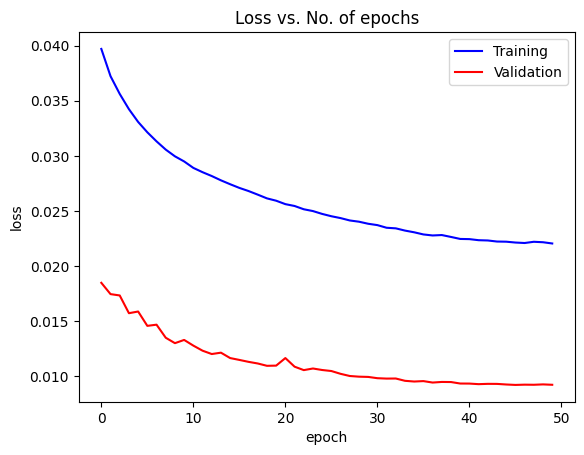

In [30]:
plot_loss(history3['train_loss'], history3['val_loss'])

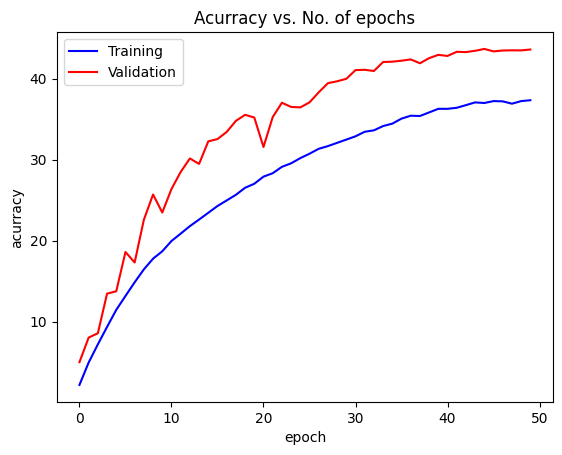

In [31]:
plot_acc(history3['train_acc'], history3['val_acc'])

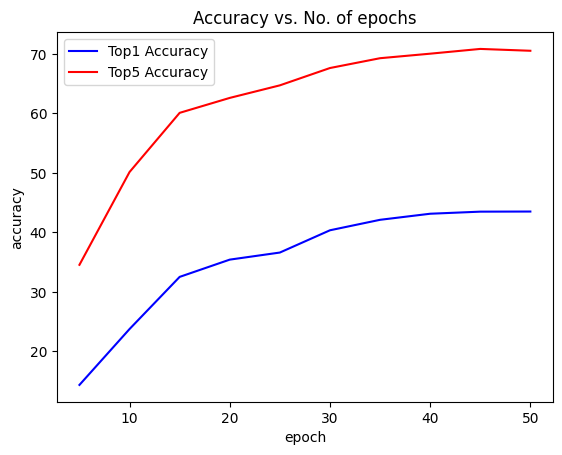

In [32]:
plot_test(history3['test_acc1'], history3['test_acc5'])

In [40]:
time_taken3 = np.array(history3['time'])
print("Average time per epoch for Wide_LAAResNet =", np.mean(time_taken3))

Average time per epoch for Wide_LAAResNet = 120.12974534988403


In [38]:
with open('wide_laaresnet_history_tiny_imagenet', 'wb') as f:
  pickle.dump(history3, f)